# Five-Room Dungeon Generator

The Five-Room Dungeon Generator provides GMs with a way to quickly and easily generate a custom five-room dungeon that can be incorporated into their campaign.  Simply provide the notebook with a concept and the notebook will do the rest.

> [!IMPORTANT]
> You will need an [.NET 8 SDK](https://dotnet.microsoft.com/en-us/download/dotnet/8.0) and [Polyglot](https://marketplace.visualstudio.com/items?itemName=ms-dotnettools.dotnet-interactive-vscode) to get started with this notebook using .NET Interactive.

## Step 1 - Initial Configuration


Choose whether you wish to use the OpenAI or Azure OpenAI service.

In [41]:
bool useAzureOpenAI = false;

Execute the following code which will ask a few questions and save the settings to a local
`settings.json` configuration file, under the [config](config) folder. You can
also edit the file manually if you prefer. **Please keep the file safe.**

In [42]:
#!import config/Settings.cs

await Settings.AskAzureEndpoint(useAzureOpenAI);
await Settings.AskModel(useAzureOpenAI);
await Settings.AskApiKey(useAzureOpenAI);

// Uncomment this if you're using OpenAI and need to set the Org Id
await Settings.AskOrg(useAzureOpenAI);

Settings: OK: AI model configured [config/settings.json]
Settings: OK: API key configured [config/settings.json]


If you want to reset the configuration and start again, please uncomment and run the code below.
You can also edit the [config/settings.json](config/settings.json) manually if you prefer.

In [43]:
#!import config/Settings.cs

// Uncomment this line to reset your settings and delete the file from disk.
// Settings.Reset();

## Step 2 - Instantiate Services

Set up the Microsoft Semantic AI Kernel that will use for generative operations.

In [57]:

#r "nuget: Microsoft.SemanticKernel, 1.11.1"
#r "nuget: Microsoft.SemanticKernel.Planners.Handlebars, 1.11.1-preview"
#r "nuget: System.Numerics.Tensors, 8.0.0"
#r "nuget: SkiaSharp, 2.88.3"

#!import config/Settings.cs
#!import config/Utils.cs
#!import config/SkiaUtils.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.TextToImage;
using Microsoft.SemanticKernel.Embeddings;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using System.Numerics.Tensors;

#pragma warning disable SKEXP0001, SKEXP0010

var builder = Kernel.CreateBuilder();

// Configure AI backend used by the kernel
var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId) = Settings.LoadFromFile();

if (useAzureOpenAI)
{
    builder.AddAzureOpenAITextEmbeddingGeneration("text-embedding-ada-002", azureEndpoint, apiKey);
    builder.AddAzureOpenAIChatCompletion(model, azureEndpoint, apiKey);
    builder.AddAzureOpenAITextToImage("dall-e-3", azureEndpoint, apiKey);
}
    
else
{
    builder.AddOpenAITextEmbeddingGeneration("text-embedding-ada-002", apiKey, orgId);
    builder.AddOpenAIChatCompletion(model, apiKey, orgId);
    builder.AddOpenAITextToImage(apiKey, orgId);
}

var kernel = builder.Build();

// Get AI service instance used to generate images
var dallE = kernel.GetRequiredService<ITextToImageService>();

// Get AI service instance used to extract embedding from a text
var textEmbedding = kernel.GetRequiredService<ITextEmbeddingGenerationService>();

Installed Packages Microsoft.SemanticKernel, 1.11.1 Microsoft.SemanticKernel.Planners.Handlebars, 1.11.1-preview SkiaSharp, 2.88.3 System.Numerics.Tensors, 8.0.0

Import custom plugins from plugin directory.

In [58]:
var pluginsDirectory = Path.Combine(System.IO.Directory.GetCurrentDirectory(), "..", "plugins");

var kernel = builder.Build();
kernel.ImportPluginFromPromptDirectory(Path.Combine(pluginsDirectory, "GMToolsPlugin"));

Set up the Handlebars Planner that will be used for orchestrating generative operations.

In [59]:
using Microsoft.SemanticKernel.Planning.Handlebars;

#pragma warning disable SKEXP0060

var planner = new HandlebarsPlanner();

## Step 3 - Define Your Concept

Define your five-room dungeon concept.

In [60]:
var concept = @"
You are a game master for a Dungeons and Dragons campaign.
Please create a five-room dungeon for a party of 4 level 5 characters.
The five-room dungeon should be of medium difficulty and take place in a forest.
The party consists of a fighter, a wizard, a cleric, and a rogue.
The party is on a quest to retrieve a magical artifact from a bandit camp.
Ensure that the output includes:
* the five-room dungeon outline, 
* descriptive text for each room in the outline, 
* a list of NPCs and monsters that the party will encounter, and
* a description of the VTT map for the dungeon.
Please output the generated information into a single consolidated markdown document.
";

## Step 4 - Develop an Execution Plan

Have the planner generate an executiong plan based on the provided concept and kernel plugins.

In [61]:
#pragma warning disable SKEXP0060

// Generate a plan for the concept
var executionPlan  = await planner.CreatePlanAsync(kernel, concept);
Console.WriteLine(executionPlan);

{{!-- Step 1: Extract key values --}}
{{set "gameSystem" "Dungeons and Dragons"}}
{{set "inputContext" "A five-room dungeon in a forest with medium difficulty for a party of 4 level 5 characters on a quest to retrieve a magical artifact from a bandit camp. The party consists of a fighter, a wizard, a cleric, and a rogue."}}

{{!-- Step 2: Generate the five-room dungeon outline --}}
{{set "fiveRoomDungeon" (GMToolsPlugin-FiveRoomDungeon game_system=gameSystem input_context=inputContext)}}

{{!-- Step 3: Generate descriptive text for each room --}}
{{set "room1Description" (GMToolsPlugin-RoomDescription input_context=fiveRoomDungeon room_number="1")}}
{{set "room2Description" (GMToolsPlugin-RoomDescription input_context=fiveRoomDungeon room_number="2")}}
{{set "room3Description" (GMToolsPlugin-RoomDescription input_context=fiveRoomDungeon room_number="3")}}
{{set "room4Description" (GMToolsPlugin-RoomDescription input_context=fiveRoomDungeon room_number="4")}}
{{set "room5Description" (G

## Step 5 - Execute the Plan
Execute the plan and generate the five-room dungeon outline and room descriptions.

In [62]:
#pragma warning disable SKEXP0060

var executionPlanResult = await executionPlan.InvokeAsync(kernel, new KernelArguments());

Console.WriteLine(executionPlanResult.ToString());

# Five Room Dungeon Outline and Description

## Dungeon Outline
## Room 1: Entrance and Guardian
* **Objective:** Create an initial challenge.
* **Design:** The entrance to the bandit camp is hidden within a dense thicket in the forest. The path is guarded by two bandit scouts and a trained wolf. The scouts are alert and will sound an alarm if they spot the party, summoning reinforcements if not dealt with quickly and quietly.

## Room 2: Puzzle or Roleplaying Challenge
* **Objective:** Engage players with non-combat interaction.
* **Design:** After dealing with the scouts, the party finds a small clearing with a makeshift bandit shrine dedicated to a forest spirit. The shrine is enchanted and requires a specific offering or a prayer to pass through without triggering a magical alarm. The players can either deduce the correct offering through investigation and knowledge checks or attempt to communicate with the spirit through roleplaying.

## Room 3: Trick or Setback
* **Objective:** I

Save the output to the filesystem as `five-room-dungeon.md` in the `output` directory.

In [63]:
// Delete all contents of the directory
var outputDirectory = Path.Combine(System.IO.Directory.GetCurrentDirectory(), "..", "output");

// Write the variable executionPlanResults to a file
File.WriteAllText(Path.Combine(outputDirectory, "five-room-dungeon.md"), executionPlanResult.ToString());

## Step 6 - Generate a Map

Generate a map for the five-room dungeon.

Generated Map Description:
A TTRPG battle map.  Create a forested dungeon map with five rooms connected by a winding path: the entrance guarded by scouts and a wolf in Room 1; a clearing with an enchanted shrine and forest spirit in Room 2; a rigged storage tent hiding a bandit mage in Room 3; a large, fortified tent with the bandit leader and elite guards in Room 4; and the leader's tent containing the magical artifact and a revealing letter in Room 5.



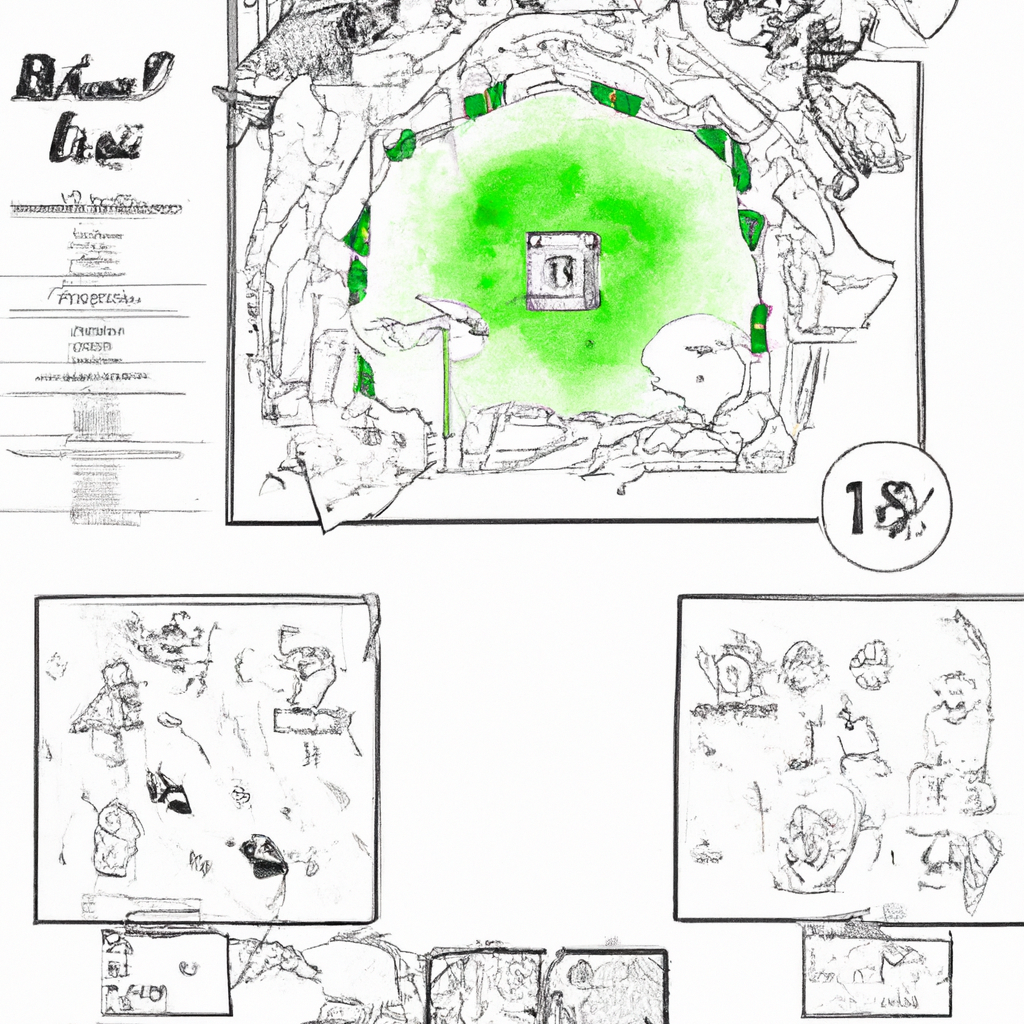

In [87]:
#pragma warning disable SKEXP0001

var prompt = @"
You are a map maker's assistant. You need to describe a map to a map maker who will then make it.
Given the five-room dungeon outline provided below, describe the map that the map maker should create.
Describe only the layout of the map.
Do not include any details about the NPCs or monsters that the party will encounter.
Do not include any details about the five-room dungeon plot.

```
{{$input_context}}
```
";

var executionSettings = new OpenAIPromptExecutionSettings 
{
    MaxTokens = 1024,
    Temperature = 1
};

// Create a semantic function that generate a random image description.
var genImgDescription = kernel.CreateFunctionFromPrompt(prompt, executionSettings);

var random = new Random().Next(0, 200);
var imageDescriptionResult = await kernel.InvokeAsync(genImgDescription, new() { ["input_context"] = executionPlanResult.ToString() });
var imageDescription = "A TTRPG battle map for the following five-room dungeon:\n\n  " + imageDescriptionResult.ToString();
imageDescription = imageDescription.Substring(0, imageDescription.Length > 1000 ? 1000 : imageDescription.Length);
Console.WriteLine("Generated Map Description:");
Console.WriteLine(imageDescription);

// Use DALL-E 3 to generate an image. OpenAI in this case returns a URL (though you can ask to return a base64 image)
var imageUrl = await dallE.GenerateImageAsync(imageDescription.Trim(), 1024, 1024);

await SkiaUtils.ShowImage(imageUrl, 1024, 1024);